In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold

from utils import plot_confusion_matrix, OneHotEncoder, clean_and_filter

print(tf.__version__)
print(tf.keras.__version__)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
2.2.4-tf


Here we use a corpus of 438 MIDI files from [MuseData](http://old.musedata.org).

Those files refers to 139 classical music compositions, of which each file can represent a specific movement.

MuseData provides also some metadata, like the composer name, the scholar catalogue number, a label for the movement. 

Each composition is interlinked against the [DOREMUS knowledge base](http://data.doremus.org), a specialised music dataset dataset which gives access to the previously mentioned metadata and much more, such as the genre.

In [2]:
df = pd.read_csv('./musedata/musedata.csv', usecols = ['id', 'composer', 'genre', 'mvt', 'instrument'])
df

,mvt,genre,instrument,composer,id
0,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-01
1,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-02
2,Aria,cantata,O+V,Bach,bach-bg-cant-0001-midi1-03
3,Recitativo,cantata,O+V,Bach,bach-bg-cant-0001-midi1-04
4,Choral,cantata,O+V,Bach,bach-bg-cant-0001-midi1-06
...,...,...,...,...,...
433,Allegro,symphony,O,Mozart,mozart-bh-sym-k550-midi1-04
434,Allegro,symphony,O,Mozart,mozart-bh-sym-k551-midi1-01
435,Andante,symphony,O,Mozart,mozart-bh-sym-k551-midi1-02
436,Minuetto,symphony,O,Mozart,mozart-bh-sym-k551-midi1-03


We load the following kind of embeddings:
- complete
- without notes
- without program
- without tempo
- without time signature
- taking into account only the first 300 note groups

In [3]:
emb = KeyedVectors.load_word2vec_format('./musedata/musedata.bin')

In [4]:
ids = df.id.tolist()
data = np.array([emb[i] for i in ids])


### Experiment 1: Genre

In DOREMUS, genres are very precise and go beyond the macro-genre "Classical"

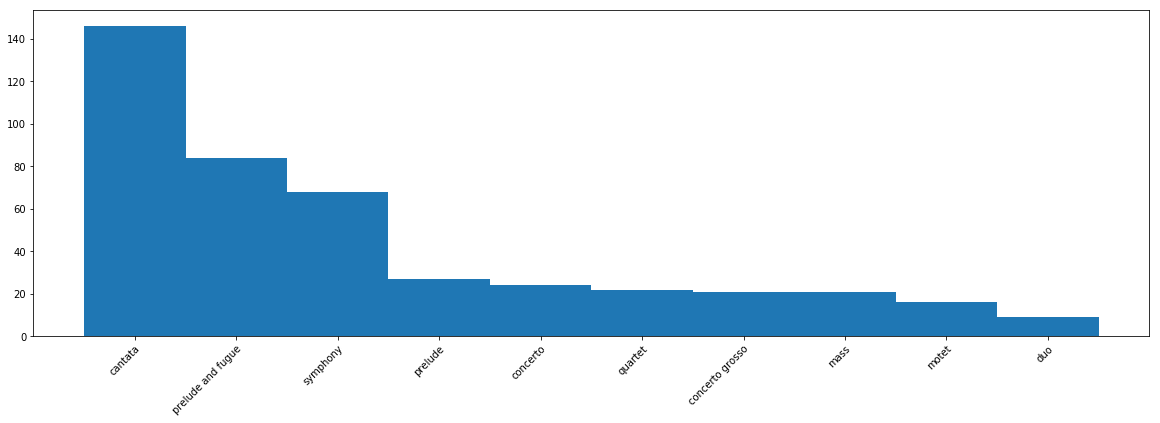

In [5]:
genres_filtered = clean_and_filter(data, df.genre, 0)

In [6]:
onehot = OneHotEncoder(df.genre.tolist())

onehot.get(onehot.labels[0])

'cantata'

In [7]:
onehot.labels.shape

(438, 10)

In [8]:
num_input = data.shape[1]
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 10)

In [9]:
def create_model(num_input, num_output):
    def m():
        model = tf.keras.Sequential()

        model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(num_output, activation='sigmoid'))

        model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

        return model
    return m

In [10]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=10, 
                                 batch_size=32,
                                 verbose=0)

In [11]:
random_state = 2111
scores = cross_val_score(neural_network, data, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_genre = np.mean(scores)
scores_genre

W0624 10:17:01.147919 4444732864 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0624 10:17:01.338602 4444732864 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.56818181 0.81818181 0.65909094 0.79545456 0.65909094 0.56818181
 0.72727275 0.75       0.88372093 0.88372093]


0.7312896490097046

In [12]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

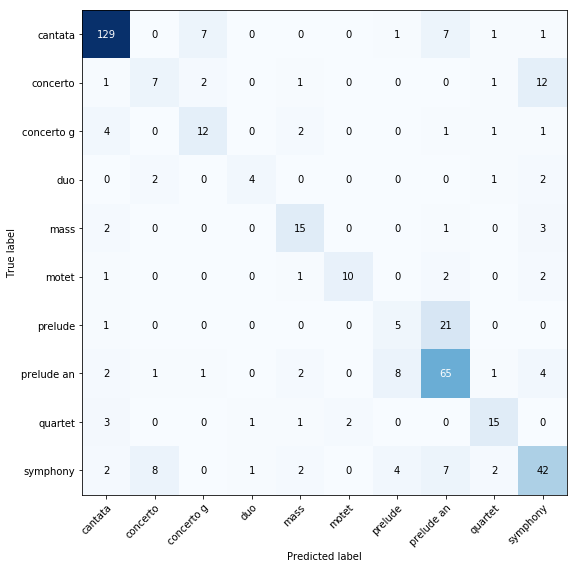

In [13]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre, title='genre')

#### Normalized confusion matrix

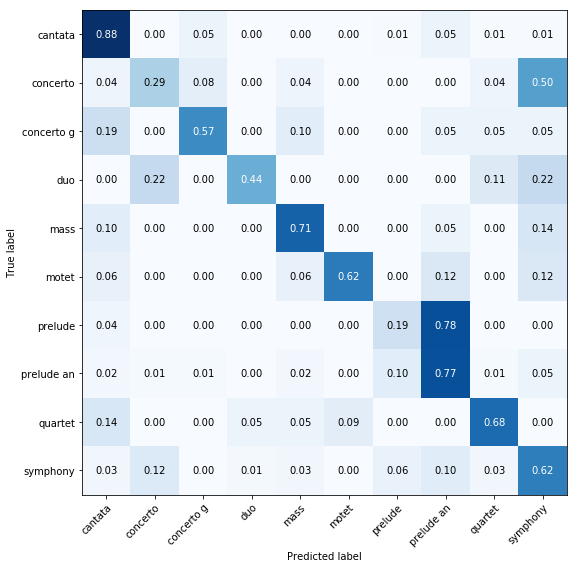

In [14]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre, normalize=True, title='genre')

### Experiment 2: Composer

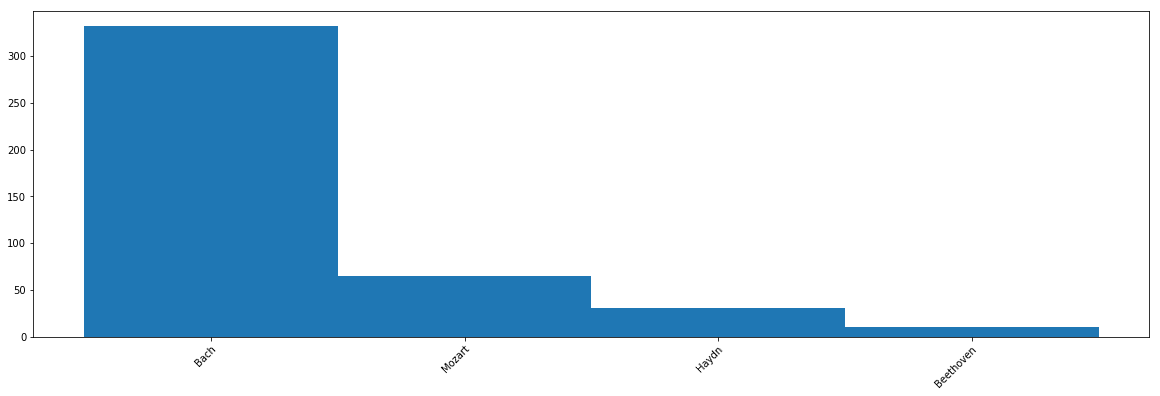

In [15]:
composer_filtered = clean_and_filter(data, df.composer, 0)

In [16]:
onehot = OneHotEncoder(df.composer)

num_output = onehot.labels.shape[1]
num_output

4

In [17]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose = 0)

In [18]:
random_state = 2111
scores = cross_val_score(neural_network, data, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_composer = np.mean(scores)
scores_composer

[0.95454544 0.81818181 0.93181819 0.97727275 0.93181819 0.86363637
 0.86363637 0.88636363 0.88372093 0.93023258]


0.9041226267814636

In [19]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

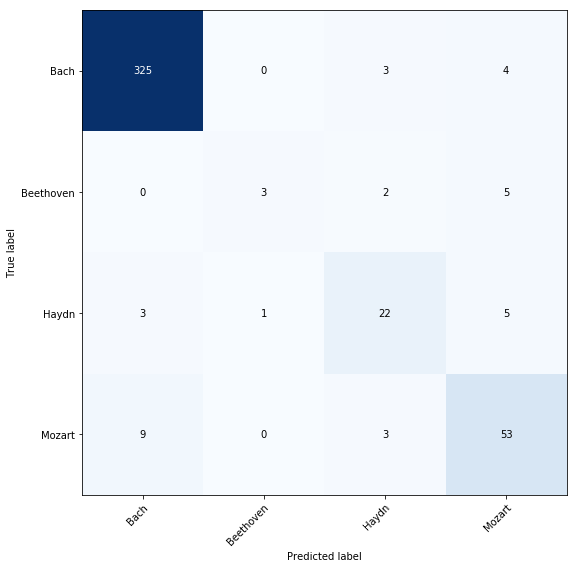

In [20]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.composer, title='composer')

#### Normalized confusion matrix

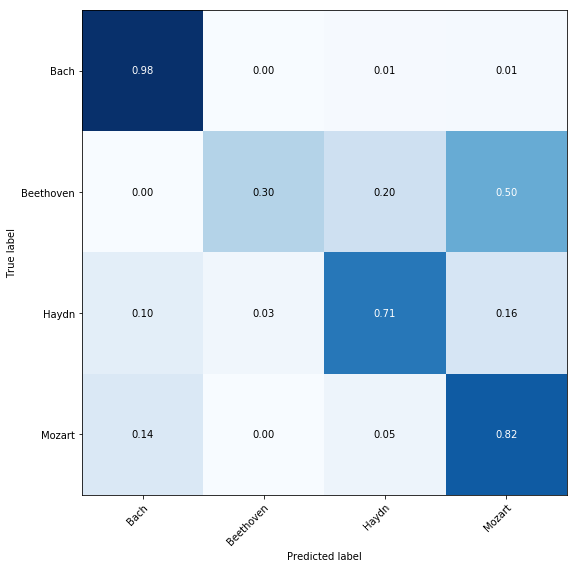

In [21]:
plot_confusion_matrix(onehot.labels, predicted, df.composer, normalize=True, title='composer')

### Experiment 3: Movement

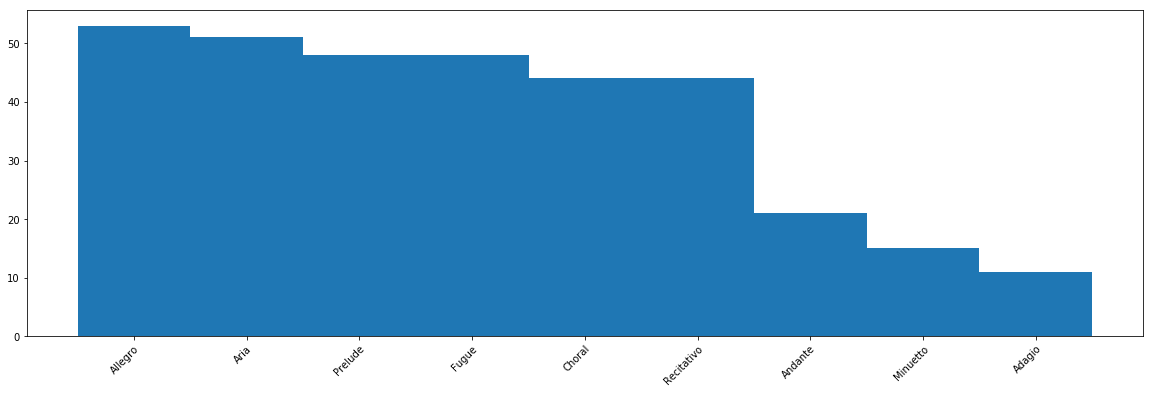

Distinct movement tag considered:


9

In [22]:
data_filtered, mvt_filtered = clean_and_filter(data, df.mvt, min_count=9)
print('Distinct movement tag considered:')
len(np.unique(mvt_filtered))

In [23]:
onehot = OneHotEncoder(mvt_filtered)

num_output = onehot.labels.shape[1]
num_output

9

In [24]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=10, 
                                 batch_size=32, verbose=0)

In [25]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_mvt = np.mean(scores)
scores_mvt

[0.85294116 0.70588237 0.70588237 0.58823532 0.64705884 0.72727275
 0.72727275 0.5151515  0.4848485  0.69696969]


0.6651515245437623

In [26]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

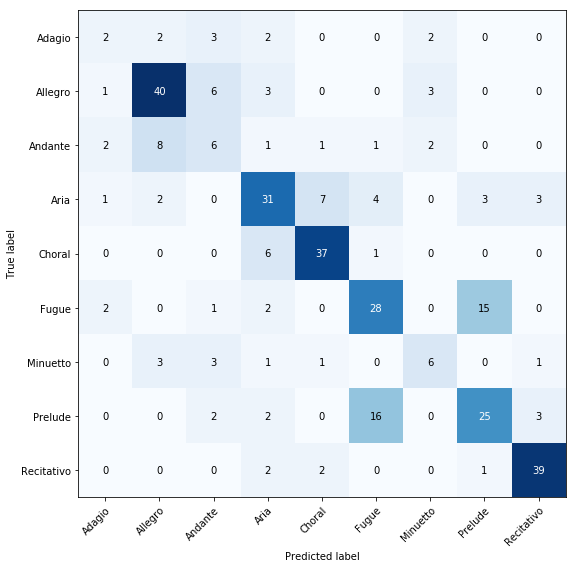

In [27]:
plot_confusion_matrix(onehot.labels, predicted, classes=mvt_filtered, title='mvt')

#### Normalized confusion matrix

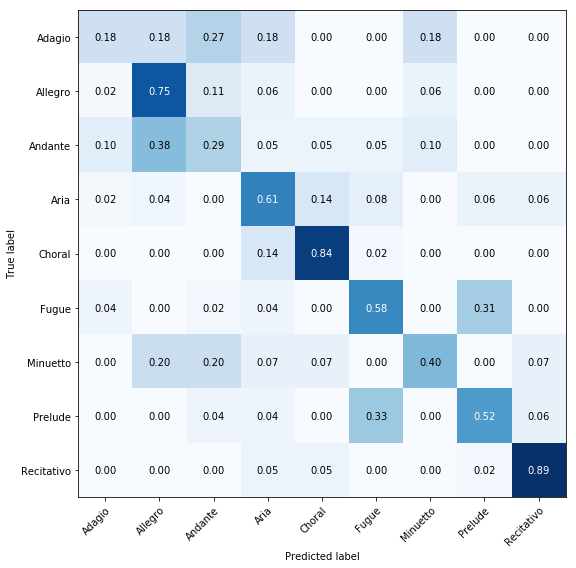

In [28]:
plot_confusion_matrix(onehot.labels, predicted, classes=mvt_filtered, normalize=True, title='mvt')

### Experiment 4: Instrument

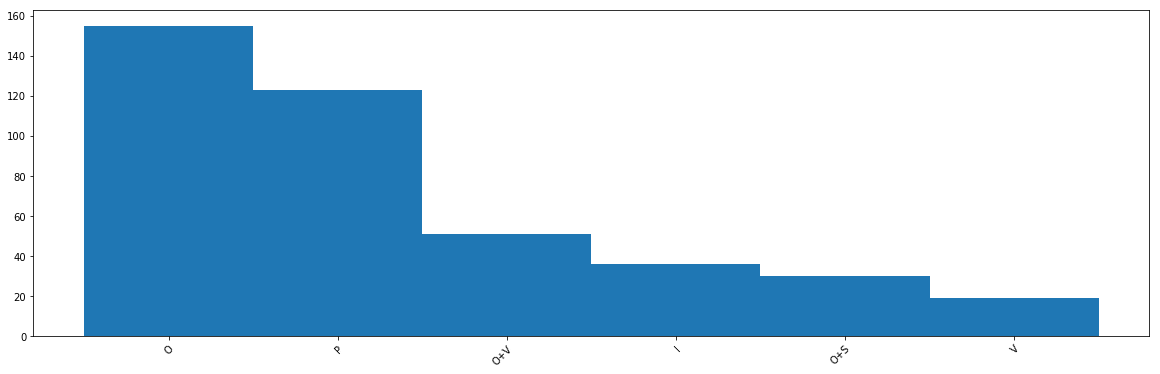

Distinct instrument considered:


6

In [29]:
data_filtered, instrument_filtered = clean_and_filter(data, df.instrument, min_count=9)
print('Distinct instrument considered:')
len(np.unique(instrument_filtered))

In [30]:
onehot = OneHotEncoder(instrument_filtered)

num_output = onehot.labels.shape[1]
num_output

6

In [31]:
neural_network = KerasClassifier(build_fn=create_model(num_input, num_output), 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [32]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
print(scores)
scores_instrument = np.mean(scores)
scores_instrument

[0.69047618 0.78571427 0.73809522 0.83333331 0.65853661 0.60975611
 0.63414633 0.68292683 0.68292683 0.65853661]


0.6974448323249817

In [33]:
predicted = cross_val_predict(neural_network, data_filtered, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

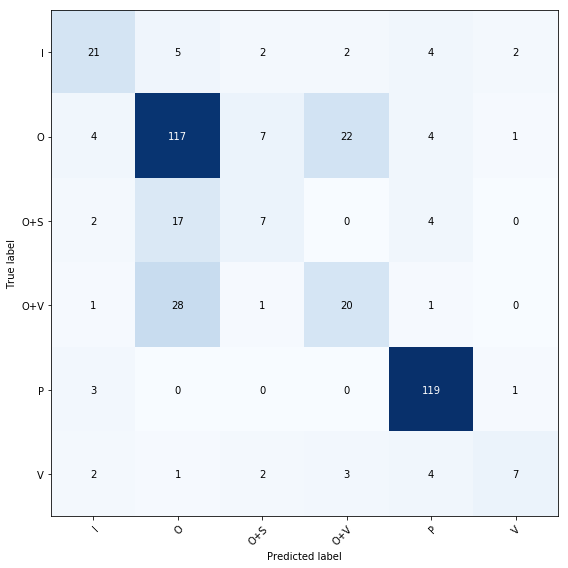

In [34]:
plot_confusion_matrix(onehot.labels, predicted, classes=instrument_filtered, title='instrument')

#### Normalized confusion matrix

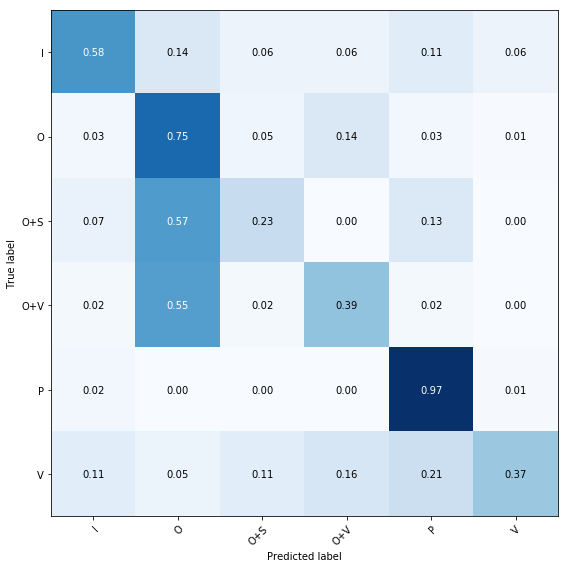

In [35]:
plot_confusion_matrix(onehot.labels, predicted, classes=instrument_filtered, normalize=True, title='instrument')

Export the results for publication

In [37]:
res = pd.DataFrame.from_dict([{
    'name': 'genre',
    'score': scores_genre
  },{ 
    'name': 'composer',
    'score': scores_composer
  },{
    'name': 'mvt',
    'score': scores_mvt
  },{
    'name': 'instrument',
    'score': scores_instrument
}])
res

,name,score
0,genre,0.731290
1,composer,0.904123
2,mvt,0.665152
3,instrument,0.697445


In [38]:
res.to_latex('musedata.classification.latex',index=False)

# 2D Visualisation with TSNE

Picture saved at ./img/tsne-musedata-genre.pdf


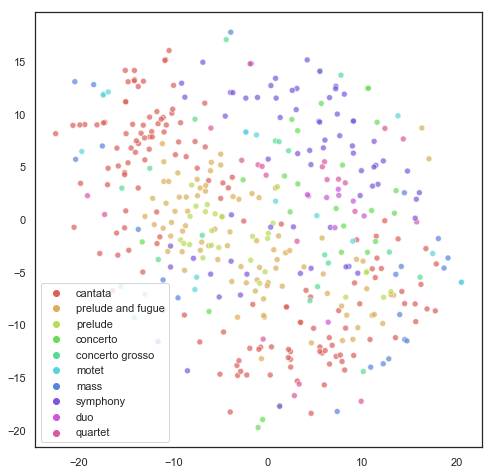

In [39]:
from utils import plot
plot(data, labels=df.genre.tolist(), output='./img/tsne-musedata-genre.pdf')

Picture saved at ./img/tsne-musedata-composer.pdf


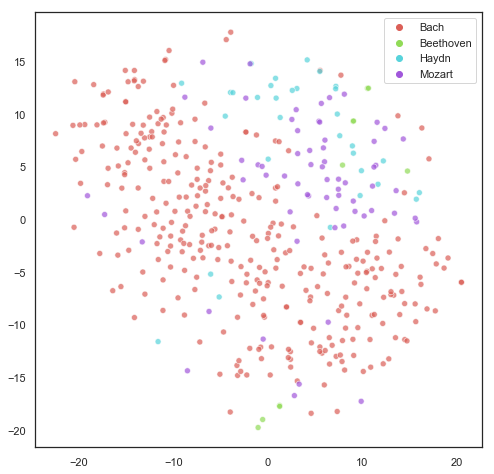

In [40]:
plot(data, labels=df.composer.tolist(), output='./img/tsne-musedata-composer.pdf')

Picture saved at ./img/tsne-musedata-mvt.pdf


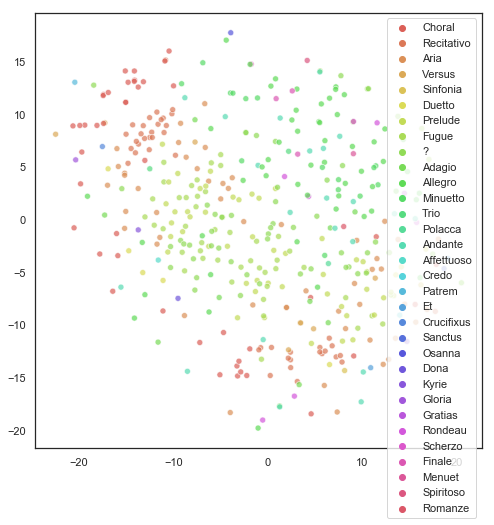

In [41]:
plot(data, labels=df.mvt.tolist(), output='./img/tsne-musedata-mvt.pdf')

Picture saved at ./img/tsne-musedata-instrument.pdf


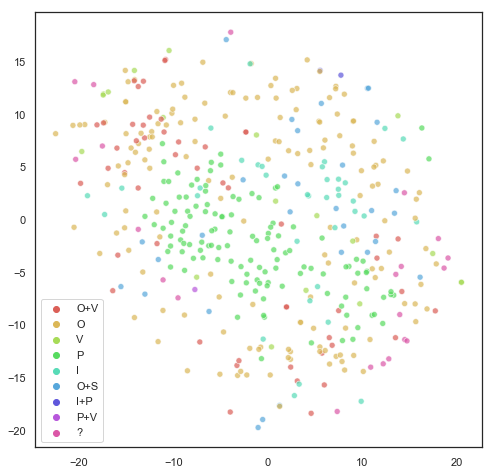

In [42]:
plot(data, labels=df.instrument.tolist(), output='./img/tsne-musedata-instrument.pdf')